In [1]:
from fastbook import *
from fastai.vision.widgets import *

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '092ccf676dcc48ceab05a9e499b3c8fb')

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [4]:
results = search_images_bing(key, 'Simmental cattle')
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
ims = ['https://learnnaturalfarming.com/wp-content/uploads/2020/04/Simmental-cattle-.jpg']

In [6]:
dest = 'images/Simmental cattle.jpg'
download_url(ims[0], dest)

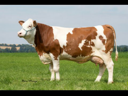

In [9]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [10]:
cow_types = 'Angus cattle', 'Shorthorn', 'Limousin cattle', 'Simmental cattle'
path = Path('cows')

In [11]:
if not path.exists():
    path.mkdir()
    for o in cow_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cow')
        download_images(dest, urls=results.attrgot('content_url'))


 Download of http://www.topwebsites24-7.com/upl/blocks/194/images/2160/image.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p cows/Shorthorn
$ cd cows/Shorthorn
$ wget -c http://www.topwebsites24-7.com/upl/blocks/194/images/2160/image.jpg
$ tar xf image.jpg
 And re-run your code once the download is successful




 Download of http://www.jensensimmentals.com/T5M1_071607.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p cows/Simmental cattle
$ cd cows/Simmental cattle
$ wget -c http://www.jensensimmentals.com/T5M1_071607.jpg
$ tar xf T5M1_071607.jpg
 And re-run your code once the download is successful



In [12]:
fns = get_image_files(path)
fns

(#584) [Path('cows/Angus cattle/00000038.jpg'),Path('cows/Angus cattle/00000010.jpg'),Path('cows/Angus cattle/00000004.jpg'),Path('cows/Angus cattle/00000005.jpg'),Path('cows/Angus cattle/00000011.jpg'),Path('cows/Angus cattle/00000039.jpg'),Path('cows/Angus cattle/00000013.jpg'),Path('cows/Angus cattle/00000012.jpg'),Path('cows/Angus cattle/00000006.jpg'),Path('cows/Angus cattle/00000002.JPG')...]

In [13]:
failed = verify_images(fns)
failed

(#27) [Path('cows/Angus cattle/00000002.JPG'),Path('cows/Angus cattle/00000047.jpg'),Path('cows/Angus cattle/00000042.jpg'),Path('cows/Angus cattle/00000026.jpg'),Path('cows/Limousin cattle/00000112.jpg'),Path('cows/Limousin cattle/00000115.jpg'),Path('cows/Limousin cattle/00000049.jpg'),Path('cows/Limousin cattle/00000088.jpg'),Path('cows/Limousin cattle/00000078.jpg'),Path('cows/Limousin cattle/00000124.jpg')...]

In [14]:
failed.map(Path.unlink);

In [15]:
cows = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128))

In [16]:
dls = cows.dataloaders(path)

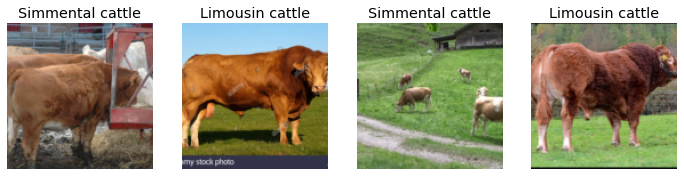

In [17]:
dls.valid.show_batch(max_n=4, nrows = 1)

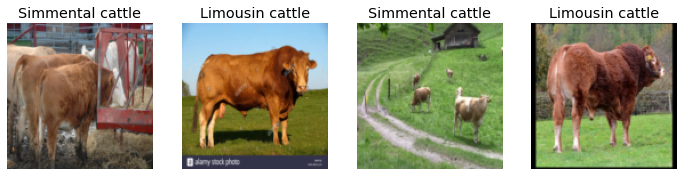

In [18]:
cows = cows.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cows.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows = 1)

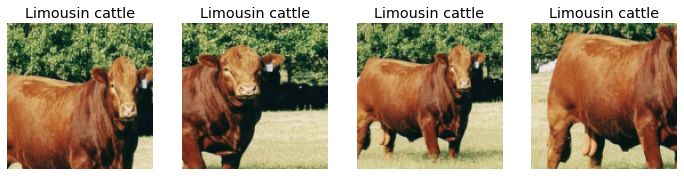

In [19]:
cows = cows.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cows.dataloaders(path)
dls.train.show_batch(max_n = 4, nrows = 1, unique = True)

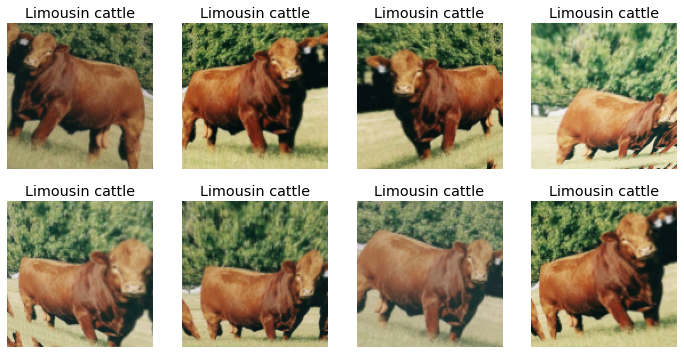

In [20]:
cows = cows.new(item_tfms=Resize(128), batch_tfms = aug_transforms(mult = 2))
dls = cows.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

In [21]:
cows = cows.new(
    item_tfms=RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms=aug_transforms())
dls = cows.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.172459,1.530924,0.495495,00:58


epoch,train_loss,valid_loss,error_rate,time
0,1.297721,0.818572,0.234234,01:17
1,1.131153,0.649107,0.216216,01:16
2,0.975897,0.645448,0.234234,01:21
3,0.886919,0.626022,0.207207,01:26


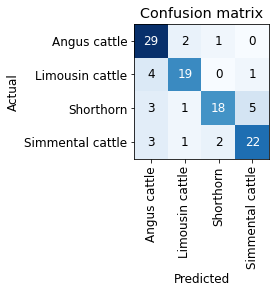

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

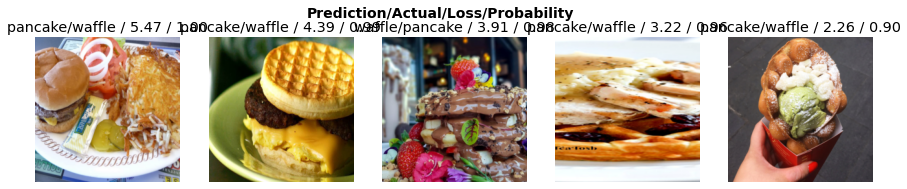

In [54]:
interp.plot_top_losses(5, nrows = 1)

In [56]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/siddharthsah/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [57]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [58]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)